## Toronto Neighborhood Venues

### In this project, we will be exploring Toronto Neighborhood Venues and Clustering them into Segmentation based on different Radius and Neighbor Clusters to find out how they are relatable to each other and to find out which type of Venue Category will be suitable to begin Business with in different Locations or Neighborhoods

###### Importing Necessary Libraries will be requiring this project

In [1]:
!pip3 install folium
import bs4
from bs4 import BeautifulSoup
import csv
import requests
import time
import pandas as pd
import urllib
import re
import pickle
from geopy.geocoders import Nominatim
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

###### Web Sacrapping the Postal Address with Boroughs and Neighborhood from the Wikipedia -->  "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" and Storing it into a DataFrame

In [2]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page=requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find_all("table", {"class":"wikitable"})

Postal = []
Borough = []
Neighborhood = []

for t in table:
    rows = t.find_all('tr')
    
    for row in rows:
        cells = row.find_all('td')
        
        
        if len(cells) > 1:
            rank = cells[0]
            Postal.append((rank.text))
            
            country = cells[1]
            Borough.append(country.text.strip())
            
            rate = cells[2]
            Neighborhood.append((rate.text.strip()))


Postal=[p.replace('\n','') for p in Postal]#.replace('\n','')

df=pd.DataFrame(list(zip(Postal,Borough,Neighborhood)),columns =['PostalCode', 'Borough','Neighborhood'])
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


###### Cleaning the Dataframe with removing the row with Borough having value as 'Not Assigned' 

In [3]:
df_filtered = df[df['Borough'] != 'Not assigned']
df_filtered.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
df_filtered.shape

(103, 3)

###### Importing Latitude and Longitude for the Postal Code 

In [5]:
geo=pd.read_csv('http://cocl.us/Geospatial_data')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


###### Merging Both the Dataframe on the Basis of Postal Code into a single dataframe

In [6]:
geo.rename(columns = {'Postal Code':'PostalCode'},inplace=True)
df_geo=df_filtered.merge(geo,how='inner',on='PostalCode')
df_geo.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Clustering Toronto Neighborhood Data

In [7]:
Toronto_df=df_geo[df_geo['Borough'].str.contains('Toronto')]
Toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [8]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Plotting Toronto Map with Neighborhood

In [9]:
Map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Map_Toronto)  
    
Map_Toronto

### Explore Toronto Neighborhood with FourSquare API with limit 100 and radius as 1km

In [10]:
CLIENT_ID = 'LSMVAULVQZHMP5LZEISYYFR3FXYLTQ0UXOJWROHKETWH1MEG' # your Foursquare ID
CLIENT_SECRET = '5EJCBCLLM3D4YQKBZQITOFJGMITLXG4DBAUXKFFSJYPZCIVF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value
radius=1000


##### Creating Function to gennerate dataframe of nearby neighborhoods with their Latitude and Longitude

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Calling the Function on Toronto Data

In [12]:
Toronto_venues=getNearbyVenues(names=Toronto_df['Neighborhood'],
                               latitudes=Toronto_df['Latitude'],
                               longitudes=Toronto_df['Longitude'])
Toronto_venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
3,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
4,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center


In [13]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


##### Now let's see the Most Frequent Venue Category  in each Neighborhood to gain insights 

In [14]:
temp3=pd.DataFrame(Toronto_venues.groupby(['Venue Category','Neighborhood'])['Venue Category'].count())

temp3.rename(columns={'Venue Category':'Venue Category Count'},inplace=True)

#temp3.reset_index(level=0, inplace=True)

temp4=temp3[temp3['Venue Category Count']>7]
temp4.head()

Venue Category Count
Venue Category Neighborhood                                                   
Café           High Park, The Junction South                                 8
               Kensington Market, Chinatown, Grange Park                    10
               Little Portugal, Trinity                                      8
               Richmond, Adelaide, King                                      8
               University of Toronto, Harbord                               10

##### Plotting the Bar Plot to see the distribution

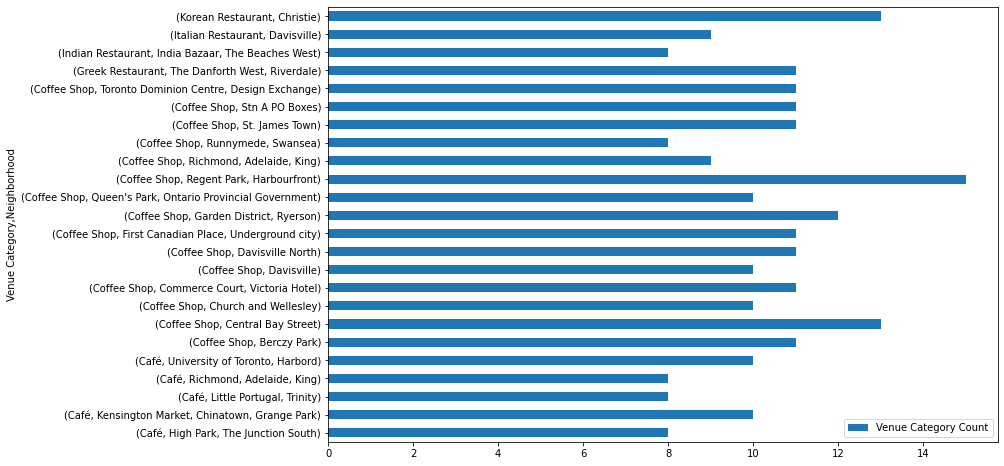

In [15]:
temp4.plot(kind='barh',figsize=(12,8))

### Analyze Each Neighborhood

In [16]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Zoo,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Zoo,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.00,0.0,0.0000,0.0000,0.010000,0.0,0.0,0.0,...,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.01,0.0,0.0000,0.0000,0.010000,0.0,0.0,0.0,...,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,"Business reply mail Processing Centre, South C...",0.0,0.00,0.0,0.0000,0.0000,0.021277,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.00,0.0,0.0625,0.0625,0.000000,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,Central Bay Street,0.0,0.00,0.0,0.0000,0.0000,0.010000,0.0,0.0,0.0,...,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02


##### Get the N number of Top Venues of Each Neighborhood

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Café,Hotel,Park,Japanese Restaurant,Gastropub,Bakery,Restaurant,Pizza Place,Liquor Store
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Restaurant,Furniture / Home Store,Bakery,Gift Shop,Tibetan Restaurant,Indian Restaurant,Sandwich Place
2,"Business reply mail Processing Centre, South C...",Park,Brewery,Pizza Place,Fast Food Restaurant,Italian Restaurant,Bakery,Sushi Restaurant,Coffee Shop,Pub,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Harbor / Marina,Coffee Shop,Café,Dog Run,Park,Garden,Sculpture Garden,Airport,Airport Lounge,Sushi Restaurant
4,Central Bay Street,Coffee Shop,Café,Clothing Store,Ramen Restaurant,Pizza Place,Park,Sushi Restaurant,Diner,Yoga Studio,Theater


##### Applying the K-Neighbor for Clustering the Related Venues

In [20]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_df

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Café,Restaurant,Pub,Park,Theater,Italian Restaurant,Breakfast Spot,Sushi Restaurant,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Park,Pizza Place,Sushi Restaurant,Café,Japanese Restaurant,Yoga Studio,Ramen Restaurant,Middle Eastern Restaurant,Italian Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Café,Gastropub,Japanese Restaurant,Theater,Pizza Place,Diner,Ramen Restaurant,Bookstore,Plaza
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Gastropub,Restaurant,Pizza Place,Theater,Italian Restaurant,Seafood Restaurant,Bakery,Gym
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Pub,Coffee Shop,Pizza Place,Breakfast Spot,Beach,Japanese Restaurant,Park,Bakery,Bar,Sandwich Place


##### Plot the Clustered Map to visualize the Related Venues

In [21]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,first in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels'],Toronto_merged['1st Most Common Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster)+' First Common Venue '+str(first), parse_html=True)
    if(not math.isnan(cluster)):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters

In [22]:
neighborhoods_venues_sorted=neighborhoods_venues_sorted.drop(['Cluster Labels'],axis=1)
# set number of clusters
kclusters = 7

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_df

# merge Toronto_grouped with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if(not math.isnan(cluster)):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)

map_clusters